In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Generate data

In [126]:
def generateData():
    n = 50
    d = 75
    k = 5 
    sigma = 1

    # generate x_i
    cov_mat = np.identity(d)
    avg = np.zeros((d,))
    x = np.random.multivariate_normal(avg,cov_mat,n)

    # epsilon vec
    epsilon_vec = np.random.normal(loc=0,scale=sigma)

    # w_star_0
    w_star_0 = 0
    w_star = np.zeros((d,))
    w_star[0:10] = np.random.randint(low = 1,high=3, size=10)
    w_star[w_star==2] = -1

    # generate y 
    y = np.dot(x,w_star) + w_star_0 + epsilon_vec
    
    return y,x,w_star
    
def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    lambda_vec = []
    sum_y = (1/n)*np.sum(y[:])
    for k_ind in np.arange(k):
        
        lambda_val = 2*np.abs(np.dot(x[:,k_ind].T,(y-sum_y)))
        lambda_vec.append(lambda_val)
    #import pdb; pdb.set_trace()
    lambda_max = np.max(lambda_vec)
    return lambda_max

    
### lasso!
def lasso_CD(x,y,lambda_val):
    ### initialize conditions 
    delta = 1e-10
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = np.random.random(d)
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = y - np.dot(x,w)
        w_0 = (1/n)*np.sum(diff_y_x)

        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])

            x_temp = np.delete(x,k,axis=1)
            w_temp = np.delete(w,k,axis=0)

            diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

            if c[k] < - lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (-lambda_val < c[k] < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]

        weight_diff = w - w_old
        w_old = copy.deepcopy(w)


        stop_cond = np.max(weight_diff)
        stop_cond_vec.append(stop_cond)
    
    return w,stop_cond_vec

def lasso_loop(x,y):
    w_vec = []
    
    lambda_max = lambda_max_fun(x,y)
    lambda_vec_iterate = []
    for lambda_ind in lambda_vec_iterate:
        w = lasso_CD(x,y,lambda_val)
    
    w_vec.append(w)
    return w_vec 

def plot_lasso(w,stop_cond_vec,w_star):
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax2 = plt.bar(np.arange(len(w)),1.1*w,label='computed weight matrix')
    ax3 = plt.bar(np.arange(len(w_star)),w_star,label='w*')
    plt.legend()
    plt.ylim([0,1.2])

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)
    plt.ylim([0,0.05])

In [ ]:
y,x,w_star = generateData()


In [140]:
lambda_max = lambda_max_func(x,y)
lambda_max

176.71447232770248

In [143]:

lambda_val = 100
w,stop_cond_vec = lasso_CD(x,y,lambda_val)

array([ 0.25401757,  0.        , -0.34713564,  0.        ,  0.        ,
        0.        ,  0.51474933,  0.        , -0.23147913,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

array([ 1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

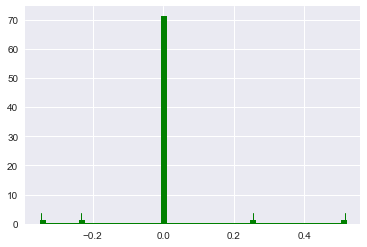

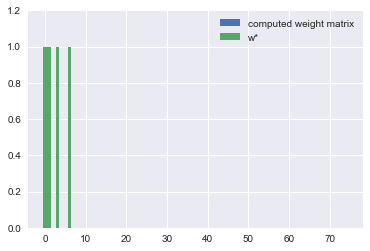

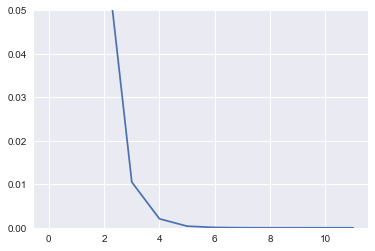

In [144]:
plot_lasso(w,stop_cond_vec,w_star)

w
w_star

In [124]:
w

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])